In [3]:
import pandas as pd
import numpy as np
import folium
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import geopandas as gpd

# 한글폰트 지정
plt.rcParams['font.family'] = 'AppleGothic'

# 한글폰트 사용 시 -기호 깨지는 문제 해결
plt.rcParams['axes.unicode_minus']=False

In [5]:
orders_data = pd.read_csv('orders_data.csv', dtype={'customer_zip_code_prefix': str})
items_data = pd.read_csv('items_data.csv', dtype={'seller_zip_code_prefix': str})

In [7]:
orders_data['order_approved_date'] = pd.to_datetime(orders_data['order_approved_date'])
orders_data['order_delivered_date'] = pd.to_datetime(orders_data['order_delivered_date'])
orders_data['order_estimated_date'] = pd.to_datetime(orders_data['order_estimated_date'])

# 2️⃣ 숫자 컬럼(float) 변환 (결측치 제거 전)
num_cols = ['customer_lat','customer_lng','total_item_price','total_freight','avg_review_score']
for col in num_cols:
    orders_data[col] = pd.to_numeric(orders_data[col], errors='coerce')

In [9]:
# 결측치 제거
orders_data = orders_data[orders_data['order_status']=='delivered']
orders_data = orders_data.dropna(subset=['order_approved_date'])
orders_data = orders_data.dropna(subset=['order_delivered_date'])
orders_data = orders_data.dropna(subset=['customer_lat'])
orders_data = orders_data.dropna(subset=['customer_lng'])
orders_data = orders_data.dropna(subset=['avg_review_score'])
items_data = items_data.dropna(subset=['seller_lat'])
items_data = items_data.dropna(subset=['seller_lng'])
itmes_data = items_data.dropna(subset=['review_score'])

In [11]:
orders = orders_data.copy()
items = items_data.copy()

In [13]:
orders_data = orders_data[orders_data['order_status']=='delivered']

orders_data[orders_data['order_status']=='delivered']

,order_id,order_status,order_approved_date,order_delivered_date,order_estimated_date,customer_id,customer_zip_code_prefix,customer_lat,customer_lng,customer_city,customer_state,total_item_price,total_freight,avg_review_score
0,03054d8a8eefc2981cfad06f58e27979,delivered,2017-10-03,2017-10-19,2017-10-25,9bd2f246e81c19f65c539ce426288ef5,03560,-23.54761,-46.49978,sao paulo,SP,58.90,15.16,5.0
1,01f48b2a27229e667db384b5b9d5dfa4,delivered,2018-05-16,2018-05-18,2018-05-28,1f4e48d20f0deaacefd7fc19a4382c65,03573,-23.55913,-46.50884,sao paulo,SP,59.90,8.29,5.0
2,04da4dc0ed95cc93f9f25375fa08ad47,delivered,2018-08-23,2018-08-29,2018-09-05,e9fa18734cb99d218c0bee8e5b02ab5c,04459,-23.69299,-46.67221,sao paulo,SP,246.90,14.39,5.0
3,0330631bdb2ec8c341f487ed9c22fc8b,delivered,2018-05-26,2018-06-07,2018-06-26,e3109970a3fe8021d5ff82c577ce5606,05528,-23.59462,-46.75724,sao paulo,SP,45.90,12.79,5.0
4,0297f94a646c942bde497bd200cce1ed,delivered,2017-12-26,2018-01-10,2018-01-19,4da495ce705cd190ddf3a36268b61142,03461,-23.56988,-46.52554,sao paulo,SP,125.00,16.50,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99428,ff834ecc7838d679d1cbd96ad32cee27,delivered,2017-06-27,2017-07-06,2017-07-21,5cbb774b043be6439aa9c5a51efea395,90220,-30.02114,-51.20967,porto alegre,RS,104.00,16.49,5.0
99432,ff7ea91a98e1590d290e99bcffefa149,delivered,2018-06-05,2018-06-12,2018-07-17,278bfabeb5197c5674271cf529588fc8,84990,-24.14260,-49.82237,arapoti,PR,69.00,19.45,5.0
99433,ffa2d919ed5fc1b6661b89904ef71b88,delivered,2018-04-19,2018-04-30,2018-05-11,8c33b5139e4f68d40b1e97f12fd40d5b,91230,-30.01830,-51.12548,porto alegre,RS,252.00,18.47,5.0
99438,ffd3ff583dec4975e6443d6a396f2f36,delivered,2017-11-23,2017-12-05,2017-12-22,480b60f05b6caa21bd6edbea402d607b,99500,-28.29124,-52.79026,carazinho,RS,156.25,15.84,5.0


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# =====================
# 1️⃣ 원본 보존
# =====================
orders = orders_data.copy()
items = items_data.copy()

# =====================
# 2️⃣ 좌표 결측/범위 이상치 제거
# =====================
# 먼저 items에 고객 좌표 merge
df = items.merge(
    orders[['order_id','customer_lat','customer_lng']],
    on='order_id',
    how='left'
)

# 결측/범위 이상치 제거
df = df.dropna(subset=["seller_lat","seller_lng","customer_lat","customer_lng"])
df = df[
    df["seller_lat"].between(-35, 10) &
    df["seller_lng"].between(-75, -30) &
    df["customer_lat"].between(-35, 10) &
    df["customer_lng"].between(-75, -30)
].copy()

# =====================
# 3️⃣ 거리 계산 (상품 단위)
# =====================
def haversine_vec(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

df['distance_km'] = haversine_vec(
    df['seller_lat'], df['seller_lng'],
    df['customer_lat'], df['customer_lng']
)

# =====================
# 4️⃣ 주문 단위 집계 (sum, mean, median, 배송비, 판매자 수)
# =====================
order_distance_sum = df.groupby('order_id', as_index=False)['distance_km'] \
                          .sum().rename(columns={'distance_km':'order_distance_km_sum'})
order_distance_mean = df.groupby('order_id', as_index=False)['distance_km'] \
                           .mean().rename(columns={'distance_km':'order_distance_km_mean'})
order_distance_median = df.groupby('order_id', as_index=False)['distance_km'] \
                             .median().rename(columns={'distance_km':'order_distance_km_median'})
order_freight_sum = df.groupby('order_id', as_index=False)['freight_value'] \
                          .sum().rename(columns={'freight_value':'order_freight_sum'})
n_shipments = df.groupby('order_id', as_index=False)['seller_id'] \
                   .nunique().rename(columns={'seller_id':'n_shipments'})

# =====================
# 5️⃣ 배송기간 & 지연 플래그
# =====================
# orders['delivery_days'] = (orders['order_delivered_date'] - orders['order_approved_date']).dt.days
orders['delivery_delay_days'] = (orders['order_delivered_date'] - orders['order_estimated_date']).dt.days

# =====================
# 6️⃣ 최종 Merge
# =====================
orders_enriched = orders.merge(order_distance_sum, on='order_id', how='left') \
                        .merge(order_distance_mean, on='order_id', how='left') \
                        .merge(order_distance_median, on='order_id', how='left') \
                        .merge(order_freight_sum, on='order_id', how='left') \
                        .merge(n_shipments, on='order_id', how='left')



In [17]:
# 7️⃣ state_summary 생성
# =====================
state_summary = (
    orders_enriched
    .groupby('customer_state')
    .agg(
        orders=('order_id', 'nunique'),
        median_price=('total_item_price', 'median'),
        late_rate=('delivery_delay_days', lambda x: (x > 0).mean())
    )
    .reset_index()
)

# =====================
# 8️⃣ 파레토 프런티어 계산 함수
# =====================
def pareto_frontier(df, maximize=['orders','median_price','late_rate'], minimize=[]):
    is_pareto = np.ones(df.shape[0], dtype=bool)
    for i, row_i in df.iterrows():
        for j, row_j in df.iterrows():
            if i == j:
                continue
            better_or_equal_max = all(row_j[m] >= row_i[m] for m in maximize)
            better_or_equal_min = all(row_j[m] <= row_i[m] for m in minimize)
            strictly_better = any(row_j[m] > row_i[m] for m in maximize) or any(row_j[m] < row_i[m] for m in minimize)
            if better_or_equal_max and better_or_equal_min and strictly_better:
                is_pareto[i] = False
                break
    return df[is_pareto]

# =====================
# 9️⃣ 파레토 후보 (주문 많고 단가 높고 지연율 높은 지역)
# =====================
pareto_candidates = pareto_frontier(
    state_summary
)

# 결과 확인
pareto_candidates

,customer_state,orders,median_price,late_rate
0,AC,80,119.450,0.037500
1,AL,393,105.000,0.208651
4,BA,3221,93.000,0.118286
5,CE,1268,99.900,0.137224
9,MA,708,98.000,0.169492
13,PA,931,105.000,0.107411
14,PB,510,109.995,0.101961
15,PE,1575,99.000,0.093968
16,PI,468,109.900,0.138889
18,RJ,12196,89.990,0.119383


In [57]:
# 후보 지역의 위도/경도 평균 계산
state_coords = (
    orders_enriched
    .groupby('customer_state')
    .agg(
        state_lat=('customer_lat', 'mean'),
        state_lng=('customer_lng', 'mean')
    )
    .reset_index()
)

# pareto_candidates와 병합
pareto_candidates_coords = pareto_candidates.merge(
    state_coords,
    on='customer_state',
    how='left'
)
pareto_candidates_coords


,customer_state,orders,median_price,late_rate,state_lat,state_lng
0,AC,80,119.450,0.037500,-9.908545,-68.060668
1,AL,393,105.000,0.208651,-9.642008,-36.038522
2,BA,3221,93.000,0.118286,-13.026063,-39.465926
3,CE,1268,99.900,0.137224,-4.329944,-38.966454
4,MA,708,98.000,0.169492,-3.577980,-44.707295
5,PA,931,105.000,0.107411,-2.378386,-49.072875
6,PB,510,109.995,0.101961,-7.088849,-35.666331
7,PE,1575,99.000,0.093968,-8.199816,-35.779378
8,PI,468,109.900,0.138889,-5.496423,-42.591615
9,RJ,12196,89.990,0.119383,-22.753264,-43.173495


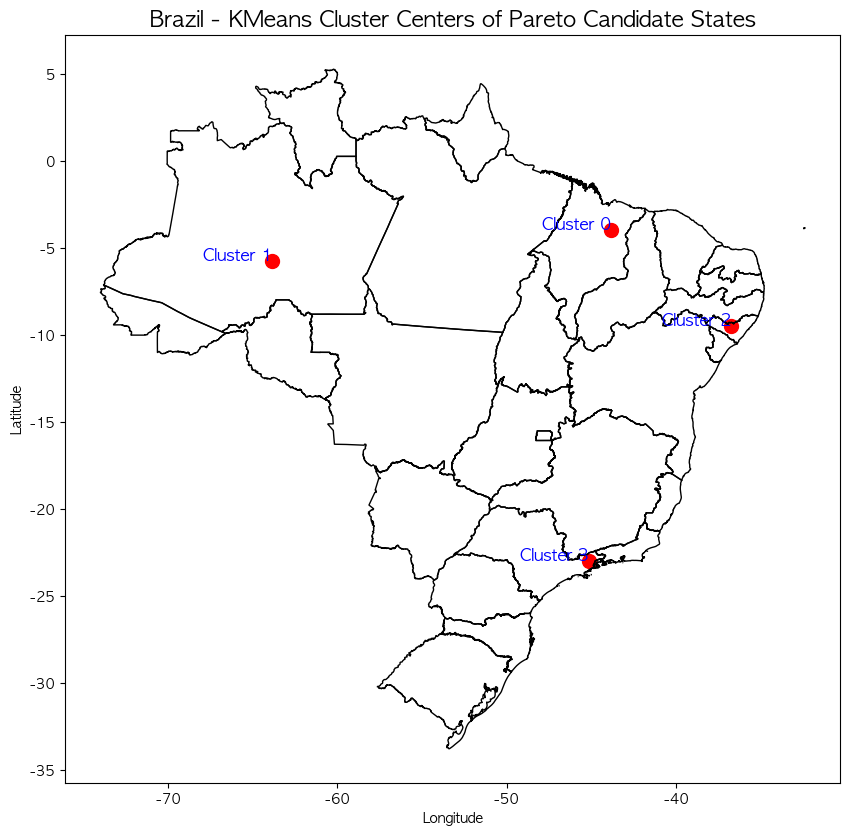

In [141]:
from sklearn.cluster import KMeans

# 사용할 데이터: 위도/경도
X = pareto_candidates_coords[['state_lat','state_lng']]

# KMeans 실행 (예: k=4)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# 각 후보 지역의 cluster 라벨
pareto_candidates_coords['cluster'] = kmeans.labels_

# cluster 중심 좌표
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['state_lat', 'state_lng'])


# 4️⃣ 지도 시각화
# =====================
# 브라질 GeoJSON
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf_states = gpd.read_file(geo_url)

# cluster_center GeoDataFrame
geometry = [Point(xy) for xy in zip(cluster_centers['state_lng'], cluster_centers['state_lat'])]
gdf_clusters = gpd.GeoDataFrame(cluster_centers, geometry=geometry, crs="EPSG:4326")

# 지도 시각화
fig, ax = plt.subplots(figsize=(10, 10))
gdf_states.boundary.plot(ax=ax, color='black', linewidth=1)
gdf_clusters.plot(ax=ax, color='red', markersize=100)

# 마커 번호 표시
for x, y, idx in zip(gdf_clusters.geometry.x, gdf_clusters.geometry.y, gdf_clusters.index):
    ax.text(x, y, f"Cluster {idx}", fontsize=12, fontweight='bold', color='blue', ha='right')

ax.set_title("Brazil - KMeans Cluster Centers of Pareto Candidate States", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()



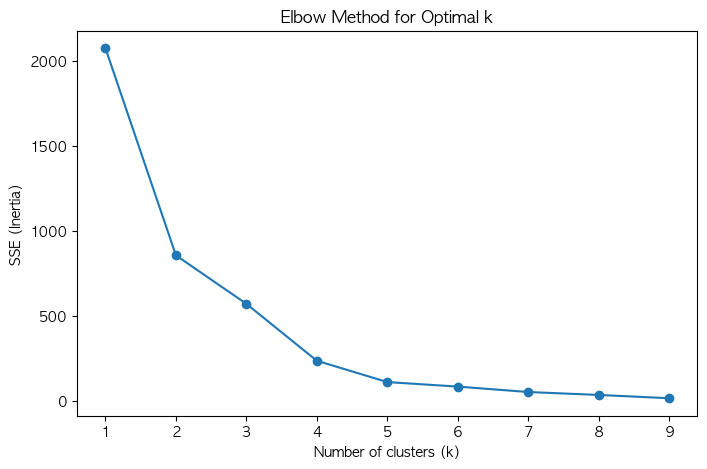

In [135]:
## 후보 지역 좌표
X = pareto_candidates_coords[['state_lat', 'state_lng']]

# =====================
# 1️⃣ 엘보우 방법: SSE 계산
# =====================
sse = []
k_range = range(1, 10)  # 1~9 클러스터 시도

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # inertia_: 클러스터 내 제곱합(SSE)

# =====================
# 2️⃣ 그래프 그리기
# =====================
plt.figure(figsize=(8,5))
plt.plot(k_range, sse, marker='o')
plt.xticks(k_range)
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()


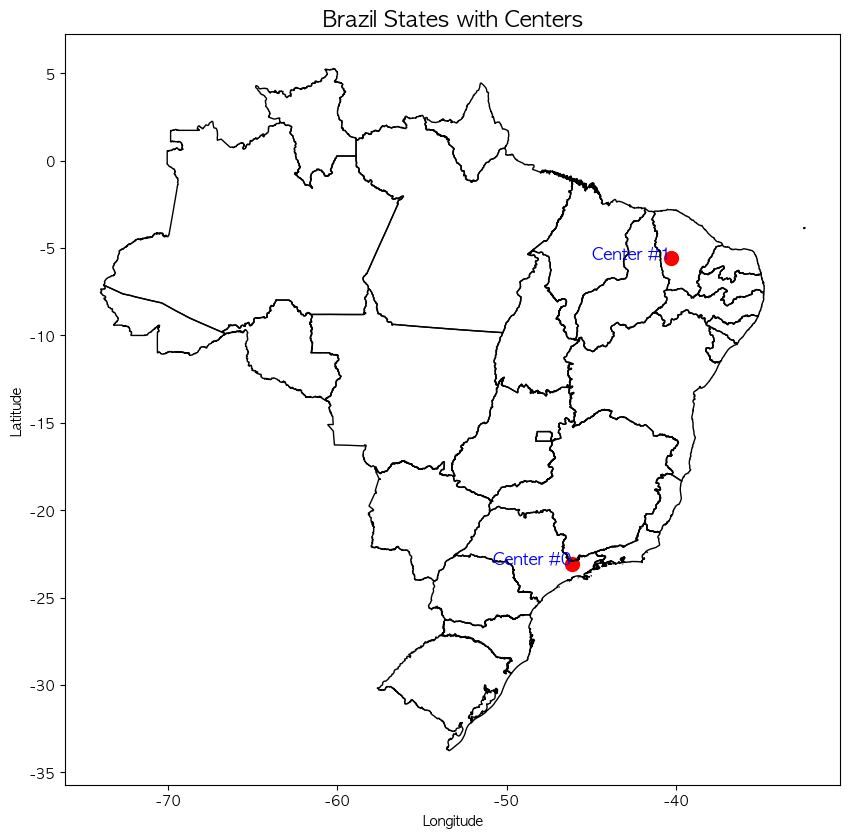

In [69]:
## 윤영님 물류 센터 위치
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# =====================
# 1️⃣ 브라질 주 GeoJSON 읽기
# =====================
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf_states = gpd.read_file(geo_url)

# =====================
# 2️⃣ 표시할 위치 정의 (Center #0, Center #1)
# =====================
locations = [
    {"name": "Center #0", "lat": -23.067873990242365, "lon": -46.14130024550238},
    {"name": "Center #1", "lat": -5.587690295427195, "lon": -40.31585097144927}
]

# Point 객체로 변환
geometry = [Point(loc['lon'], loc['lat']) for loc in locations]
gdf_points = gpd.GeoDataFrame(locations, geometry=geometry, crs="EPSG:4326")

# =====================
# 3️⃣ 지도 시각화
# =====================
fig, ax = plt.subplots(figsize=(10, 10))

# 브라질 주 경계
gdf_states.boundary.plot(ax=ax, color='black', linewidth=1)

# 위치 표시
gdf_points.plot(ax=ax, color='red', markersize=100)

# 마커에 이름 표시
for x, y, label in zip(gdf_points.geometry.x, gdf_points.geometry.y, gdf_points['name']):
    ax.text(x, y, label, fontsize=12, fontweight='bold', color='blue', ha='right')

# 제목
ax.set_title("Brazil States with Centers", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


In [91]:
### 다시... 해본 ... 코드....!


# =====================
# 1️⃣ 원본 보존
# =====================
orders = orders_data.copy()
items = items_data.copy()

# =====================
# 2️⃣ 좌표 결측/범위 이상치 제거
# =====================
df2 = items.merge(
    orders[['order_id','customer_lat','customer_lng']],
    on='order_id',
    how='inner'
)

df2 = df2[
    df2["seller_lat"].between(-35, 10) &
    df2["seller_lng"].between(-75, -30) &
    df2["customer_lat"].between(-35, 10) &
    df2["customer_lng"].between(-75, -30) ]



# =====================
# # 2.5️⃣ price 이상치 제거 (IQR 기준)
# # =====================
Q1 = df2['price'].quantile(0.25)
Q3 = df2['price'].quantile(0.75)
IQR = Q3 - Q1

# IQR 범위 내 값만 유지
df2 = df2[(df2['price'] >= Q1 - 1.5*IQR) & (df2['price'] <= Q3 + 1.5*IQR)]



# =====================
# 3️⃣ 거리 계산 (상품 단위)
# =====================
def haversine_vec(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

df2['distance_km'] = haversine_vec(
    df2['seller_lat'], df2['seller_lng'],
    df2['customer_lat'], df2['customer_lng']
)

# =====================
# 4️⃣ 주문 단위 집계
# =====================
order_distance_sum = df2.groupby('order_id', as_index=False)['distance_km'] \
                          .sum().rename(columns={'distance_km':'order_distance_km_sum'})
order_distance_mean = df2.groupby('order_id', as_index=False)['distance_km'] \
                           .mean().rename(columns={'distance_km':'order_distance_km_mean'})
order_distance_median = df2.groupby('order_id', as_index=False)['distance_km'] \
                             .median().rename(columns={'distance_km':'order_distance_km_median'})
order_freight_sum = df2.groupby('order_id', as_index=False)['freight_value'] \
                          .sum().rename(columns={'freight_value':'order_freight_sum'})
n_shipments = df2.groupby('order_id', as_index=False)['seller_id'] \
                   .nunique().rename(columns={'seller_id':'n_shipments'})



# 예시: 'price'가 상품 단가 컬럼이라 가정
order_total_price = df2.groupby('order_id', as_index=False)['price'].sum() \
                         .rename(columns={'price':'order_total_price'})
# =====================
# 5️⃣ 배송기간 & 지연 플래그
# =====================
orders['delivery_days'] = (orders['order_delivered_date'] - orders['order_approved_date']).dt.days
orders['delivery_delay_days'] = (orders['order_delivered_date'] - orders['order_estimated_date']).dt.days

# =====================
# 6️⃣ 최종 Merge
# =====================
orders_enriched = orders.merge(order_distance_sum, on='order_id', how='left') \
                        .merge(order_distance_mean, on='order_id', how='left') \
                        .merge(order_distance_median, on='order_id', how='left') \
                        .merge(order_freight_sum, on='order_id', how='left') \
                        .merge(n_shipments, on='order_id', how='left')\
                        .merge(order_total_price, on='order_id', how='left')


# =====================


# =====================
# 8️⃣ state_summary 생성 (전체 주문 기준 지연율)
# =====================
total_orders = len(orders_enriched)

state_summary_total = (
    orders_enriched
    .groupby('customer_state')
    .agg(
        orders=('order_id', 'nunique'),
        median_price=('order_total_price', 'median'),
        late_rate= ('delivery_delay_days', lambda x: (x > 0).mean() * 100)
    )
    .reset_index()
)

state_summary_total['late_rate'] = state_summary_total['late_rate'].round(2)

# =====================
# 9️⃣ 파레토 프런티어 계산
# =====================
def pareto_frontier(df, maximize=['orders','median_price','late_rate'], minimize=[]):
    is_pareto = np.ones(df.shape[0], dtype=bool)
    for i, row_i in df.iterrows():
        for j, row_j in df.iterrows():
            if i == j:
                continue
            better_or_equal_max = all(row_j[m] >= row_i[m] for m in maximize)
            better_or_equal_min = all(row_j[m] <= row_i[m] for m in minimize)
            strictly_better = any(row_j[m] > row_i[m] for m in maximize) or any(row_j[m] < row_i[m] for m in minimize)
            if better_or_equal_max and better_or_equal_min and strictly_better:
                is_pareto[i] = False
                break
    return df[is_pareto]

pareto_candidates = pareto_frontier(
    state_summary_total,
    maximize=['orders','median_price','late_rate'],
    minimize=[]
)

# 결과 확인
pareto_candidates



,customer_state,orders,median_price,late_rate
1,AL,393,89.900,20.87
3,AP,66,99.990,3.03
5,CE,1268,84.990,13.72
9,MA,708,82.495,16.95
13,PA,931,86.990,10.74
14,PB,510,90.900,10.20
15,PE,1575,89.000,9.40
16,PI,468,94.900,13.89
18,RJ,12196,84.900,11.94
20,RO,240,95.990,2.92


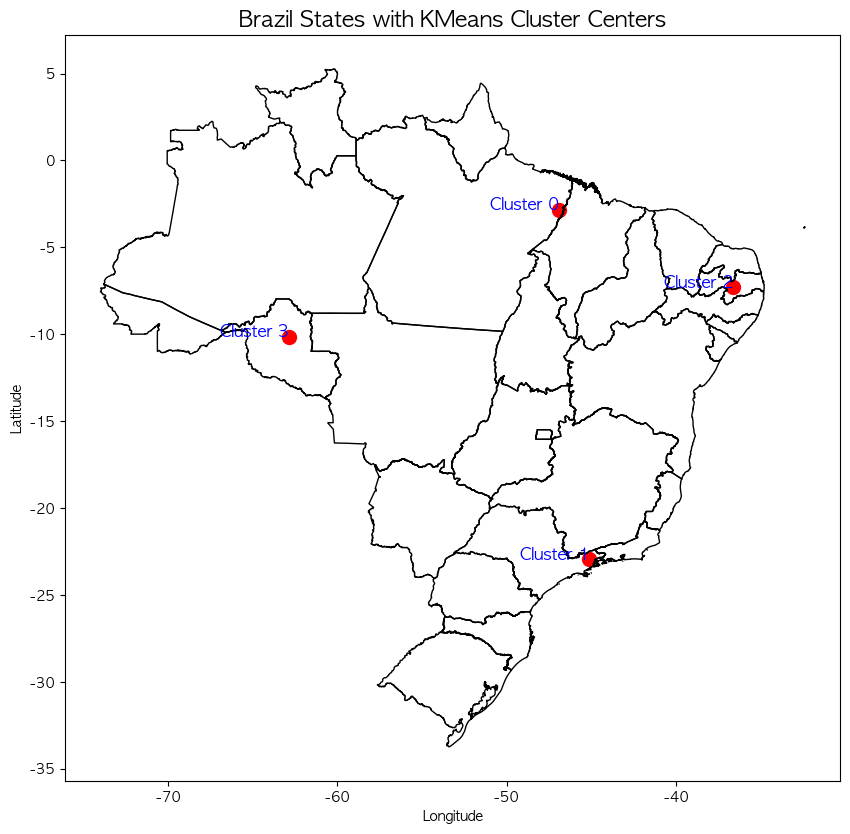

In [89]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import KMeans

# =====================
# 1️⃣ 각 주별 평균 좌표 계산
# =====================
state_coords = (
    orders_enriched
    .groupby('customer_state')
    .agg(
        state_lat=('customer_lat', 'mean'),
        state_lng=('customer_lng', 'mean')
    )
    .reset_index()
)

# =====================
# 2️⃣ pareto_candidates에 좌표 병합
# =====================
pareto_candidates_coords = pareto_candidates.merge(
    state_coords,
    on='customer_state',
    how='left'
)

# =====================
# 3️⃣ KMeans 클러스터링
# =====================
X = pareto_candidates_coords[['state_lat','state_lng']]
k = 4  # 클러스터 수
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

pareto_candidates_coords['cluster'] = kmeans.labels_

cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['lat','lng'])
geometry = [Point(xy) for xy in zip(cluster_centers['lng'], cluster_centers['lat'])]
gdf_clusters = gpd.GeoDataFrame(cluster_centers, geometry=geometry, crs="EPSG:4326")

# =====================
# 4️⃣ 브라질 지도 시각화
# =====================
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf_states = gpd.read_file(geo_url)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_states.boundary.plot(ax=ax, color='black', linewidth=1)
gdf_clusters.plot(ax=ax, color='red', markersize=100)

for x, y, idx in zip(gdf_clusters.geometry.x, gdf_clusters.geometry.y, gdf_clusters.index):
    ax.text(x, y, f"Cluster {idx}", fontsize=12, fontweight='bold', color='blue', ha='right')

ax.set_title("Brazil States with KMeans Cluster Centers", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


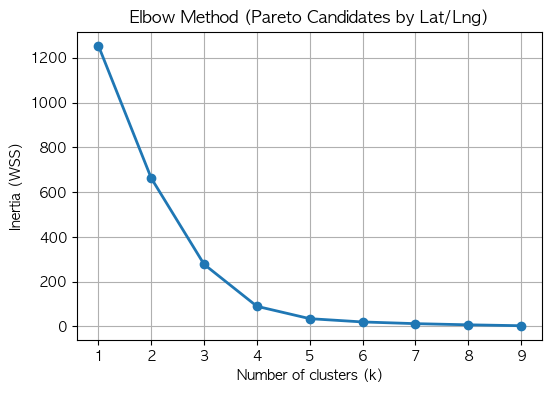

In [87]:
# =====================
# 1️⃣ 주별 평균 좌표 구하기
# =====================
state_coords = (
    orders_enriched.groupby('customer_state')
    .agg(
        state_lat=('customer_lat', 'mean'),
        state_lng=('customer_lng', 'mean')
    )
    .reset_index()
)

# pareto 후보군에 좌표 merge
pareto_geo = pareto_candidates.merge(state_coords, on='customer_state', how='left')

# =====================
# 2️⃣ Elbow Method (좌표만 사용)
# =====================
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = pareto_geo[['state_lat','state_lng']].values

inertia = []
K = range(1, 10)  # k=1~9까지 테스트

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# =====================
# 3️⃣ 시각화
# =====================
plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'o-', linewidth=2)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WSS)")
plt.title("Elbow Method (Pareto Candidates by Lat/Lng)")
plt.grid(True)
plt.show()
